## Buildings de Seattle - Prédiction de la consommation d'énergie

#### Mission

La mission est de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour la ville de Seattle.  
On cherche également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions.



#### [Importation des données nettoyées](#importation-donnees)
 - [Suppression des colonnes State, City, DataYear](#suppression-des-colonnes-state-city-datayear)

#### [Variables cibles](#cibles)
 - [Distributions des variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions](#distributions-des-variables-cibles-siteenergyusekbtu-et-totalghgemissions)
 - [Liens entre les variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions](#liens-entre-les-variables-cibles-siteenergyusekbtu-et-totalghgemissions)
 - [Distributions des variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions à échelle logarithmique](#distributions-cibles-log)

#### [Séparation des données](#separation-donnees)
 - [Isolation des données d'identification](#isolation-identification)
 - [Isolation des données liées à l'Energy Star Score](#isolation-energy-star)

#### [Préparation du Preprocessor](#preparation-preprocessor)  
 - [Installation de category_encoders](#installation-de-category_encoders)
 - [Données catégorielles et numériques](#separation-categorielles-numeriques)
 - [Preprocessor](#preprocessor)
  
#### [Préparation des jeux d'entraînement et de test](#entrainement-test)

#### [Modèles linéaires](#lineaire)
 - [DummyRegressor: l'algorithme simple qui fera office de baseline](#dummyregressor)
 - [Régression Ridge](#ridge)
 - [Régression Lasso](#lasso)

#### [Modèles non linéaires](#non-lineaire)
 - [Bagging](#bagging) 
 - [RandomForestRegressor](#randomforestregressor)

#### [Comparaison des différents modèles](#comparaison-modeles)
 - [Comparaison des métriques](#comparaison-metrics) 
 - [Diagramme à barres groupées des Mean Absolute Error et des temps de modélisation](#diagramme-mae-temps)

#### [Analyse détaillée du modèle RandomForestRegressor pour la variable SiteEnergyUse(kBtu)](#analyse-randomforest-seu)
 - [Scores des Mean Absolute Error en fonction des hyperparamètres du RandomForestRegressor](#hyperparametres) 
 - [Feature importance du modèle RandomForestRegressor sur la consommation d'énergie](#feature-importance-seu)
 - [Comparaison entre les valeurs réelles et les valeurs prédites (jeu de test initial)](#true-pred-seu)

<a id="importation-donnees"></a>
### Importation des données nettoyées 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

df = pd.read_csv("cleaning_exploration_seattle.csv")
df.shape

(1543, 23)

#### Suppression des colonnes State, City, DataYear

In [4]:
print ('Etat:' + str(df['State'].value_counts()))
print ('Ville:' + str(df['City'].value_counts()))
print ('Année du relevé:' + str(df['DataYear'].value_counts()))

Etat:State
WA    1543
Name: count, dtype: int64
Ville:City
Seattle    1543
Name: count, dtype: int64
Année du relevé:DataYear
2016    1543
Name: count, dtype: int64


Tous les bâtiments se situent dans la ville de Seattle, dans l'État de Wasington.  
Toutes les données ont été récoltées en 2016.

In [5]:
df.drop(['State','City', 'DataYear', 'Unnamed: 0'],axis=1, inplace=True)

<a id='cibles'></a>
### Variables cibles 

#### Distributions des variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions

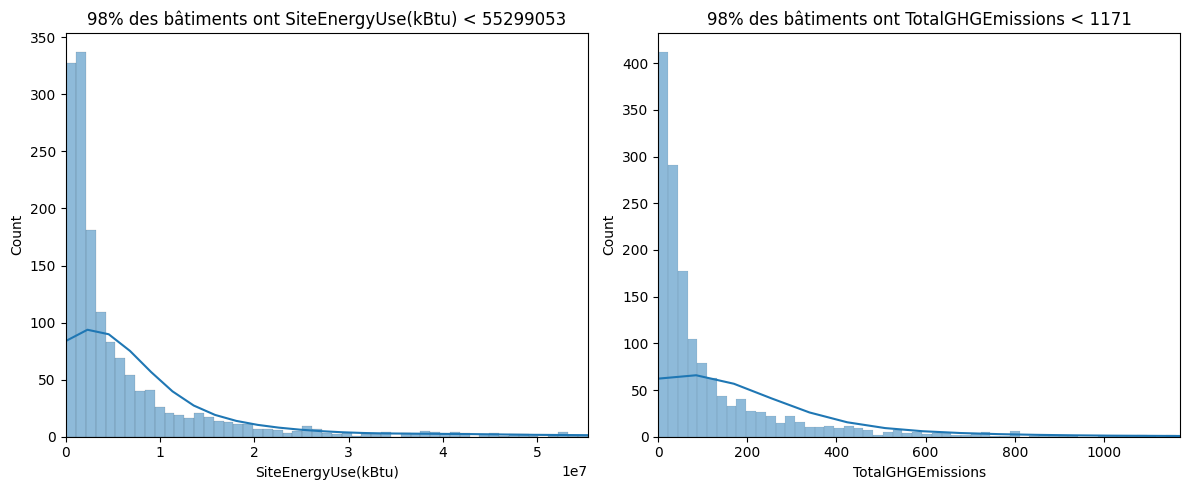

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='SiteEnergyUse(kBtu)', alpha=0.5, kde=True)
plt.title(f'98% des bâtiments ont SiteEnergyUse(kBtu) < {df["SiteEnergyUse(kBtu)"].quantile(0.98):.0f}')
plt.xlabel('SiteEnergyUse(kBtu)')
plt.xlim((0, df["SiteEnergyUse(kBtu)"].quantile(0.98)))

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='TotalGHGEmissions', alpha=0.5, kde=True)
plt.title(f'98% des bâtiments ont TotalGHGEmissions < {df["TotalGHGEmissions"].quantile(0.98):.0f}')
plt.xlabel('TotalGHGEmissions')
plt.xlim((0, df["TotalGHGEmissions"].quantile(0.98)))

plt.tight_layout()

plt.show()


#### Liens entre les variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions

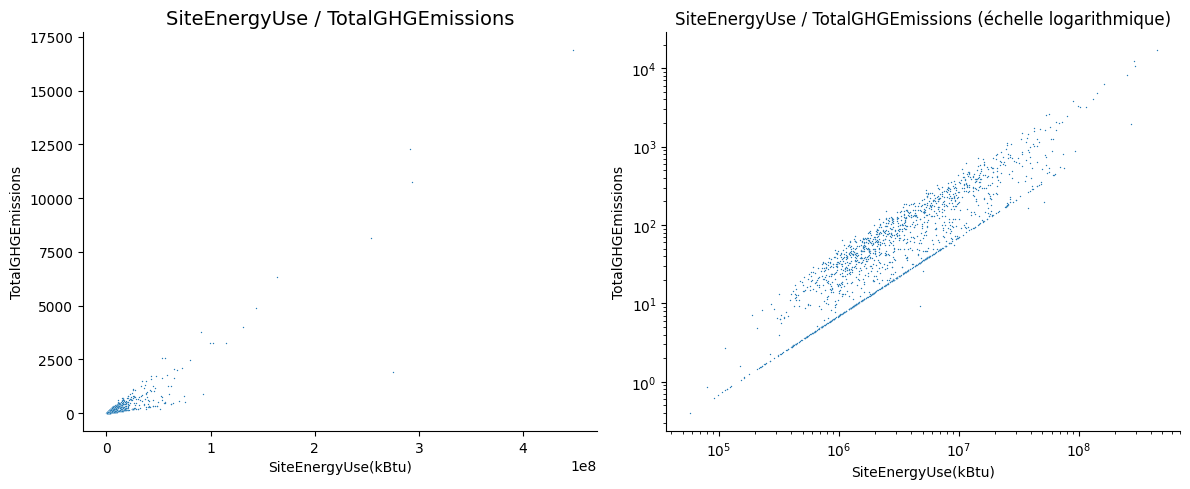

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', s=1)
sns.despine()
plt.title("SiteEnergyUse / TotalGHGEmissions", fontsize=14)
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('TotalGHGEmissions')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', s=1)
plt.xscale('log')
plt.yscale('log')
sns.despine()
plt.title("SiteEnergyUse / TotalGHGEmissions (échelle logarithmique)", fontsize=12)
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('TotalGHGEmissions')

plt.tight_layout()

plt.show()


<a id="distributions-cibles-log"></a>
#### Distributions des variables cibles SiteEnergyUse(kBtu) et TotalGHGEmissions à échelle logarithmique

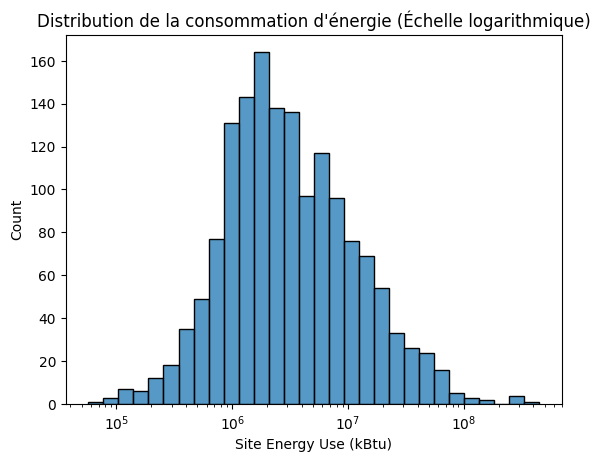

In [8]:
sns.histplot(data=df, x='SiteEnergyUse(kBtu)', bins=30, log_scale=True)

plt.xlabel('Site Energy Use (kBtu)')
plt.ylabel('Count')
plt.title('Distribution de la consommation d\'énergie (Échelle logarithmique)')

plt.show()


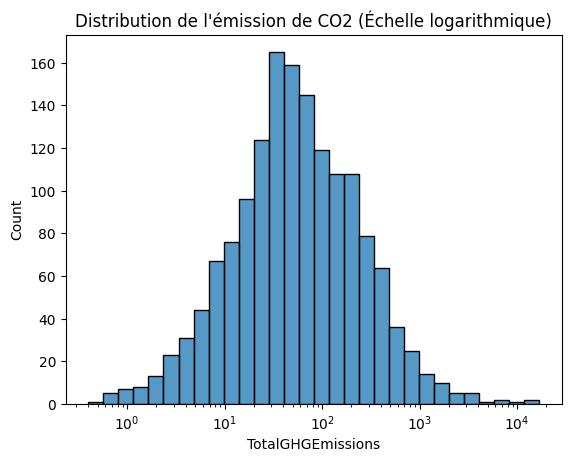

In [9]:
sns.histplot(data=df, x='TotalGHGEmissions', bins=30, log_scale=True)

plt.xlabel('TotalGHGEmissions')
plt.ylabel('Count')
plt.title('Distribution de l\'émission de CO2 (Échelle logarithmique)')

plt.show()

Les ditributions des variables cible en échelle logarithmique sont normales.  
**On utilisera en partie le logarithme pour mener nos différents modèles de prédiction.**

<a id="separation-donnees"></a>
### Séparation des données

<a id="isolation-identification"></a>
#### Isolation des données d'identification

In [10]:
id_features = ['OSEBuildingID','PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode']
df_id = df[id_features]
df.drop(id_features, axis=1, inplace = True)

<a id="isolation-energy-star"></a>
#### Isolation des données liées à l'EnergyStar Score

In [11]:
energy_star_scores_features = ['ENERGYSTARScore','YearsENERGYSTARCertified']
df_energy_star_score = df[energy_star_scores_features]
df.drop(energy_star_scores_features, axis=1, inplace = True)

<a id="preparation-preprocessor"></a>
### Préparation du Preprocessor

#### Installation de category_encoders

In [ ]:
!python3 -m pip install category_encoders

<a id="separation-categorielles-numeriques"></a>
#### Données catégorielles et numériques

In [12]:
categorical_features = df.select_dtypes(exclude=['number'])
numerical_features = df.select_dtypes(include=['number'])
print('categorical_features: ', categorical_features.columns)
print('numerical_features: ', numerical_features.columns)


categorical_features:  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood'], dtype='object')
numerical_features:  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge',
       'GFAParkingPercent', 'DowntownDistance'],
      dtype='object')


#### Preprocessor

In [13]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
target_transformer = TargetEncoder()

numeric_features = ['NumberofBuildings', 'NumberofFloors',
                            'PropertyGFATotal','BuildingAge', 'GFAParkingPercent','DowntownDistance']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

In [14]:
target_transformer

TargetEncoder()

In [15]:
numeric_transformer


RobustScaler(unit_variance=True)

In [16]:
preprocessor


ColumnTransformer(transformers=[('target', TargetEncoder(),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood']),
                                ('numeric', RobustScaler(unit_variance=True),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFATotal', 'BuildingAge',
                                  'GFAParkingPercent', 'DowntownDistance'])])

<a id="entrainement-test"></a>
### Préparation des jeux d'entraînement et de test

on fixe le jeu de test à 20% du dataset.

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = df[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes.\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1234 lignes.
Test: 309 lignes.



<a id="lineaire"></a>
### Modèles linéaires

Pour les problèmes de régression, on a différentes métriques possibles pour le paramètre scoring de la fonction GridSearchCV :  

    'neg_mean_squared_error': L'erreur quadratique moyenne négative (un score petit est meilleur).
    'neg_mean_absolute_error': L'erreur absolue moyenne négative (un score petit est meilleur).
    'r2': Le coefficient de détermination R² (proche de 1 est meilleur).

On choissit de calucler pour nos différents modèles:  
**MAE (erreur absolue moyenne)**    
**R^2 (coefficient de détermination, carré du coefficient de corrélation linéaire)**

<a id='dummyregressor'></a>
#### DummyRegressor: l'algorithme simple qui fera office de baseline

On va tout d'abors définir la fonction perform_grid_search qui sera appliquée pour chaque modèle à notre pipeline et à la méthode d'optimisation des paramètres GridSearchCV et ce pour chacun des modèles.

In [18]:
def perform_grid_search(pipeline, grid_search_key, target):

    pipeline.fit(X_train, Y_train[target])
    
    cv_results = pd.DataFrame(pipeline.named_steps[grid_search_key].cv_results_)

    df_results = pd.DataFrame.from_dict(pipeline.named_steps[grid_search_key].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    
    best_index = pipeline.named_steps[grid_search_key].best_index_
    
    test_mae = -cv_results.loc[best_index, 'mean_test_neg_mean_absolute_error']
    test_r2 = cv_results.loc[best_index, 'mean_test_r2']

    results = {
        'best_parameters': pipeline.named_steps[grid_search_key].best_params_,
        'test_mae': test_mae,
        'test_r2': test_r2,
    }
    print(target.upper())
    print("Meilleurs paramètres:", results['best_parameters'])
    print("Meilleur score MAE (test):", results['test_mae'])
    print("Meilleur score R2 (test) :", results['test_r2'])

    
    return df_results


On applique la transformation logarithmique dans notre pipeline avec la fonction TransformedTargetRegressor.  
La fonction inverse du logarithme est l'exponentielle. Elle est passée dans les prédictions.

In [19]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')


param_dummy_log = {
    "regressor__strategy": ["mean", "median", "quantile"],
    "regressor__quantile": [0.25, 0.5, 0.75]  # Only needed when strategy="quantile"
}

dummy_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_dummy_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=DummyRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_dummy_log,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])


In [20]:
print('DUMMYREGRESSOR - LOGARITHME')
SEU_dummy_log_results = perform_grid_search(dummy_grid_cv_log, 'grid_search_dummy_log', 'SiteEnergyUse(kBtu)')

DUMMYREGRESSOR - LOGARITHME


SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__quantile': 0.25, 'regressor__strategy': 'median'}
Meilleur score MAE (test): 6636926.620779146
Meilleur score R2 (test) : -0.10349190803424997


In [21]:
param_dummy = {
    "strategy": ["mean", "median", "quantile"],
    "quantile": [0.25, 0.5, 0.75] 
}

dummy_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_dummy', GridSearchCV(
                            DummyRegressor(), 
                            param_grid=param_dummy,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])


In [22]:
print('DUMMYREGRESSOR')
SEU_dummy_results = perform_grid_search(dummy_grid_cv, 'grid_search_dummy', 'SiteEnergyUse(kBtu)')

DUMMYREGRESSOR
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'quantile': 0.25, 'strategy': 'median'}
Meilleur score MAE (test): 6636926.627657028
Meilleur score R2 (test) : -0.10349190218299391


R2 négatif: le modèle ne capture la structure sous-jacente des données en échelle logarithmique.  
Modèle très inadéquat pour les données d'entraînement: il ne parvient pas à expliquer la variance observée dans les valeurs réelles.

On prend ces résultats comme baseline à laquelle on confrontera les résultats des autres modèles.

<a id="ridge"></a>
#### Régression Ridge

In [23]:
from sklearn.linear_model import Ridge

param_ridge_log = {
    "regressor__alpha": [0.1, 1.0, 10.0],
    "regressor__fit_intercept": [True, False]
}

ridge_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_ridge_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=Ridge(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_ridge_log,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])

In [24]:
print('RIDGE - LOGARITHME')
SEU_ridge_log_results = perform_grid_search(ridge_grid_cv_log, 'grid_search_ridge_log', 'SiteEnergyUse(kBtu)')

RIDGE - LOGARITHME
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__alpha': 10.0, 'regressor__fit_intercept': True}
Meilleur score MAE (test): 19439879.88061135
Meilleur score R2 (test) : -190.17932850167938


In [25]:
param_ridge = {
    "alpha": [0.1, 1.0, 10.0],
    "fit_intercept": [True, False]
}

ridge_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_ridge', GridSearchCV(
                            Ridge(), 
                            param_grid=param_ridge,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])

In [26]:
print('RIDGE')
SEU_ridge_results = perform_grid_search(ridge_grid_cv, 'grid_search_ridge', 'SiteEnergyUse(kBtu)')


RIDGE
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'alpha': 10.0, 'fit_intercept': False}
Meilleur score MAE (test): 6057767.613573426
Meilleur score R2 (test) : 0.33349841218555665


<a id="lasso"></a>
#### Régression Lasso

In [27]:
from sklearn.linear_model import Lasso

param_lasso_log = {
    "regressor__alpha": [0.1, 1.0, 10.0],
    "regressor__fit_intercept": [True, False]
}

lasso_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lasso_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=Lasso(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_lasso_log,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])

In [28]:
print('LASSO - LOGARITHME')
SEU_lasso_log_results = perform_grid_search(lasso_grid_cv_log, 'grid_search_lasso_log', 'SiteEnergyUse(kBtu)')

LASSO - LOGARITHME
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__alpha': 1.0, 'regressor__fit_intercept': True}
Meilleur score MAE (test): 5273548.23541644
Meilleur score R2 (test) : 0.09925954976617024


In [29]:
param_lasso = {
    "alpha": [0.1, 1.0, 10.0],
    "fit_intercept": [True, False]
}

lasso_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lasso', GridSearchCV(
                            Lasso(), 
                            param_grid=param_lasso,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score=True,
                            refit='neg_mean_absolute_error',
                            n_jobs=-1))
])

In [30]:
print('LASSO')
SEU_lasso_results = perform_grid_search(lasso_grid_cv, 'grid_search_lasso', 'SiteEnergyUse(kBtu)')


LASSO
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'alpha': 10.0, 'fit_intercept': False}
Meilleur score MAE (test): 6064469.30640651
Meilleur score R2 (test) : 0.33121270159008054


<a id="non-lineaire"></a>
### Modèles non linéaires

#### Bagging

In [31]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor


param_bagging_log = {
    'regressor__estimator': [RandomForestRegressor()],
    'regressor__n_estimators': [10, 50],  
    'regressor__max_samples': [0.5, 0.7], 
    'regressor__max_features': [0.5, 0.7],
    'regressor__bootstrap': [True, False]
}

bagging_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_bagging_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=BaggingRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_bagging_log,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score=True,
                            n_jobs=-1))
])

In [32]:
print('BAGGING - LOGARITHME')
SEU_bagging_log_results = perform_grid_search(bagging_grid_cv_log, 'grid_search_bagging_log', 'SiteEnergyUse(kBtu)')

BAGGING - LOGARITHME
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__bootstrap': False, 'regressor__estimator': RandomForestRegressor(), 'regressor__max_features': 0.7, 'regressor__max_samples': 0.7, 'regressor__n_estimators': 10}
Meilleur score MAE (test): 3982946.4667892293
Meilleur score R2 (test) : 0.5101155134691925


In [33]:
param_bagging = {
    'estimator': [RandomForestRegressor()],
    'n_estimators': [10, 50],  
    'max_samples': [0.5, 0.7], 
    'max_features': [0.5, 0.7],
    'bootstrap': [True, False]
}

bagging_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_bagging', GridSearchCV(
                            BaggingRegressor(), 
                            param_grid=param_bagging,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score=True,
                            n_jobs=-1))
])

In [34]:
print('BAGGING')
SEU_bagging_results = perform_grid_search(bagging_grid_cv, 'grid_search_bagging', 'SiteEnergyUse(kBtu)')

BAGGING
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'bootstrap': False, 'estimator': RandomForestRegressor(), 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}
Meilleur score MAE (test): 4062842.7587974733
Meilleur score R2 (test) : 0.6329621059280697


#### RandomForestRegressor

In [35]:
param_random_forest_log = {'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25, 50],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5,10]}

random_forest_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_random_forest_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_random_forest_log,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [36]:
print('RANDOMFOREST - LOGARITHME')
SEU_random_forest_log_results = perform_grid_search(random_forest_grid_cv_log, 'grid_search_random_forest_log', 'SiteEnergyUse(kBtu)')

RANDOMFOREST - LOGARITHME
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Meilleur score MAE (test): 3695860.535342128
Meilleur score R2 (test) : 0.6084447039846962


In [37]:
param_random_forest = {'max_features' : ['sqrt', 'log2'],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

random_forest_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_random_forest', GridSearchCV(
                            RandomForestRegressor(), 
                            param_grid=param_random_forest,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [38]:
print('RANDOMFOREST')
SEU_random_forest_results = perform_grid_search(random_forest_grid_cv, 'grid_search_random_forest', 'SiteEnergyUse(kBtu)')

RANDOMFOREST
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score MAE (test): 3878368.8967758804
Meilleur score R2 (test) : 0.6760806796149997


#### GradientBoostingRegressor

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

param_gradient_boosting_log = {
    'regressor__learning_rate': [0.01, 0.1, 0.5], # Taux d'apprentissage
    'regressor__n_estimators': [50, 100, 200],    # Nombre d'estimateurs (arbres)
    'regressor__max_depth': [3, 5, 7],            # Profondeur maximale des arbres
    'regressor__min_samples_split': [2, 5, 10],   # Nombre minimal d'échantillons pour la séparation
    'regressor__min_samples_leaf': [1, 2, 5]      # Nombre minimal d'échantillons dans les feuilles
}

gradient_boosting_grid_cv_log = Pipeline([
    ('preprocessor', preprocessor),                              
    ('grid_search_gradient_boosting_log', GridSearchCV(
        TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(),
            func=np.log,
            inverse_func=np.exp),
        param_grid=param_gradient_boosting_log,
        cv=5,
        scoring=('r2', 'neg_mean_absolute_error'),               
        refit='neg_mean_absolute_error',                         
        return_train_score=True,
        n_jobs=-1))])                                              # Utilisation de tous les cœurs disponibles


In [40]:
print('GRADIENTBOOSTING - LOGARITHME')
SEU_gradient_boosting_log_results = perform_grid_search(gradient_boosting_grid_cv_log, 'grid_search_gradient_boosting_log', 'SiteEnergyUse(kBtu)')


GRADIENTBOOSTING - LOGARITHME
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Meilleur score MAE (test): 3319480.682682385
Meilleur score R2 (test) : 0.688631721555566


In [41]:
param_gradient_boosting = {
    'learning_rate': [0.01, 0.1, 0.5], 
    'n_estimators': [50, 100, 200],    
    'max_depth': [3, 5, 7],            
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 5]      
}

gradient_boosting_grid_cv = Pipeline([
    ('preprocessor', preprocessor),                              
    ('grid_search_gradient_boosting', GridSearchCV(
        GradientBoostingRegressor(),
        param_grid=param_gradient_boosting,
        cv=5,
        scoring=('r2', 'neg_mean_absolute_error'),               
        refit='neg_mean_absolute_error',                         
        return_train_score=True,
        n_jobs=-1))])                                              

In [42]:
print('GRADIENTBOOSTING')
SEU_gradient_boosting_results = perform_grid_search(gradient_boosting_grid_cv, 'grid_search_gradient_boosting', 'SiteEnergyUse(kBtu)')


GRADIENTBOOSTING
SITEENERGYUSE(KBTU)
Meilleurs paramètres: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur score MAE (test): 3881126.8769880356
Meilleur score R2 (test) : 0.6419818448369023


<a id='comparaison-modeles'></a>
### Comparaison des différents modèles pour la variable SiteEnergyUse(kBtu)

<a id='comparaison-metrics'></a>
#### Comparaison des métriques

In [60]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
SEU_compare_metrics = pd.concat([
           pd.DataFrame(SEU_dummy_results[metrics].mean(), columns=['Dummy']),
           pd.DataFrame(SEU_ridge_results[metrics].mean(), columns=['Ridge']),
           pd.DataFrame(SEU_lasso_results[metrics].mean(), columns=['Lasso']),
           pd.DataFrame(SEU_bagging_results[metrics].mean(), columns=['Bagging']),
           pd.DataFrame(SEU_random_forest_results[metrics].mean(), columns=['RandomForest']),
          pd.DataFrame(SEU_gradient_boosting_results[metrics].mean(), columns=['GradientBoosting']),
          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['Dummy', 'Ridge',
                                            'Lasso','Bagging',
                                            'RandomForest', 'GradientBoosting'])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]

In [61]:
SEU_final_metrics_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
Dummy,0.000807,0.000954,-7.400305e+06,-7.396131e+06
Ridge,0.001720,0.001316,-6.088789e+06,-5.640949e+06
Lasso,0.002604,0.001071,-6.091326e+06,-5.641990e+06
Bagging,13.751616,0.699748,-4.443629e+06,-3.032718e+06
RandomForest,0.405756,0.023647,-4.280370e+06,-2.942698e+06
GradientBoosting,0.411521,0.003013,-4.690053e+06,-2.315224e+06


<a id='diagramme-mae-temps'></a>
#### Diagramme à barres groupées des Mean Absolute Error et des temps de modélisation

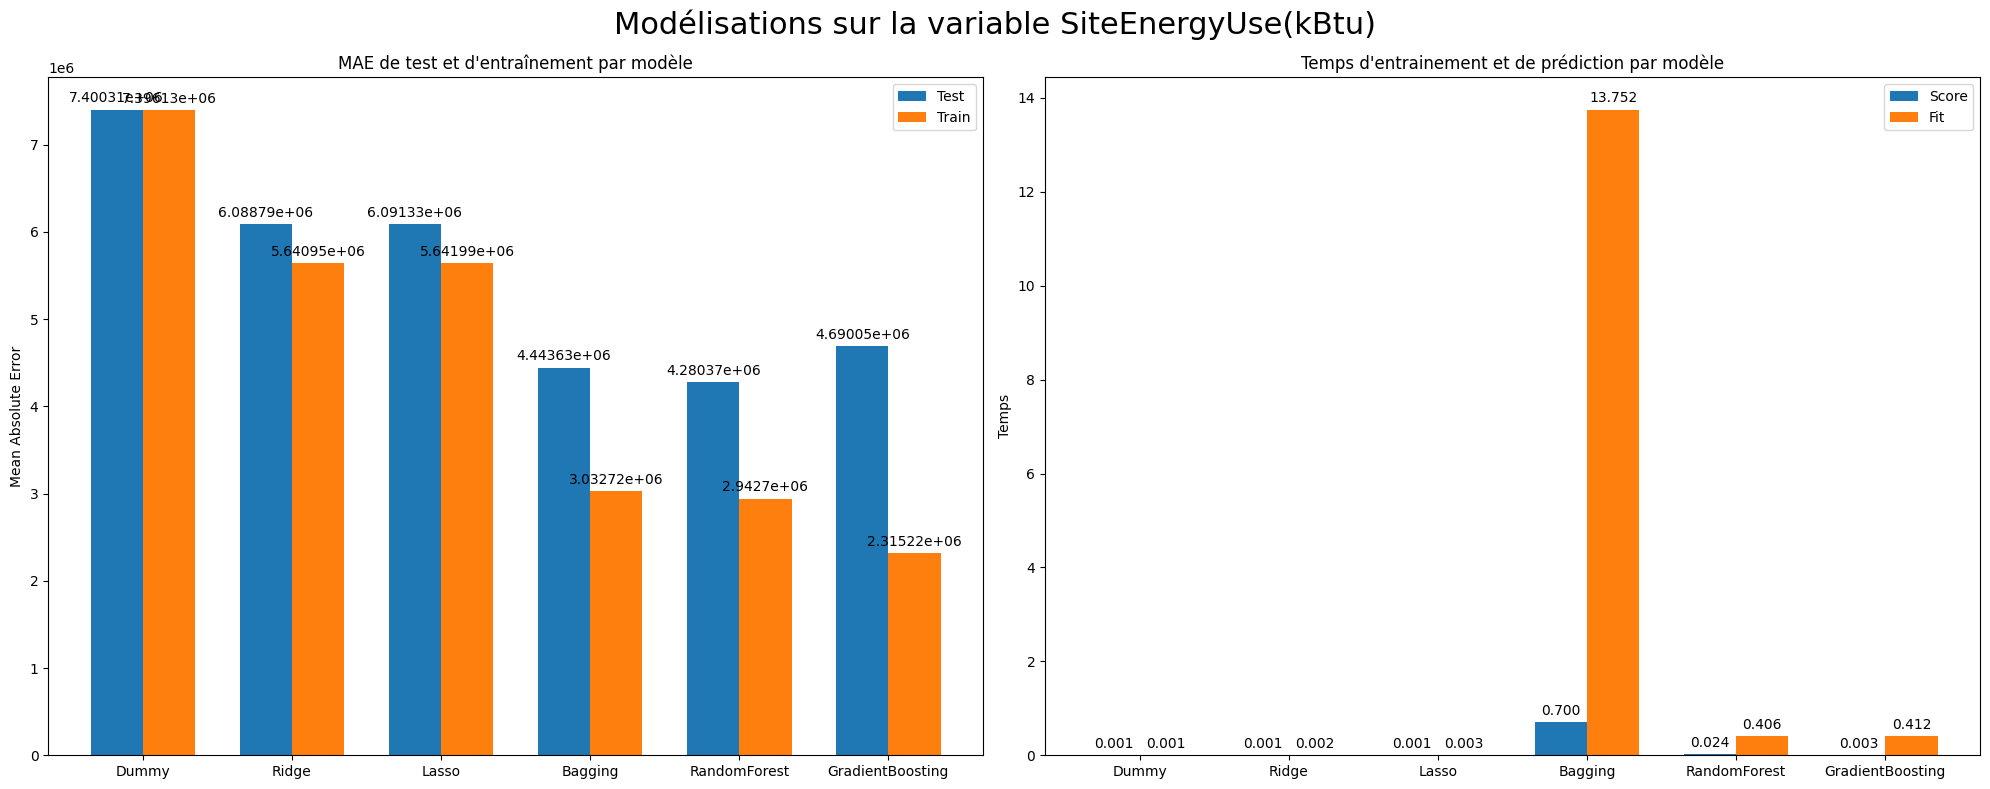

In [62]:
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*SEU_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('MAE de test et d\'entraînement par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, SEU_final_metrics_compare['mean_score_time'], width, label='Score')
times2 = ax[1].bar(x + width/2, SEU_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps')
ax[1].set_title("Temps d'entrainement et de prédiction par modèle")
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable SiteEnergyUse(kBtu)", fontsize=22)
fig.tight_layout()

plt.show()

**Les modèles non linéaires sont les plus performants.**  
Le modèle de Bagging a des temps d'entraînement de prédiction beaucoup plus longs.
Random Forest et Gradient Boosting sont relativement similaires.
Gradient Boosting a une MAE de Train et un temps de Score plus performants.   
Random Forest a de meilleurs MAE de Test et temps de Fit.   
**On retiendra Random Forest comme meilleur modèle.**

Pour Gradient Boosting, l'écart de "mean_test_neg_mean_absolute_error" et "mean_train_neg_mean_absolute_error" est relativement important: cela peut indiquer un problème de surajustement

<a id="analyse-randomforest-seu"></a>
### Analyse détaillée du RandomForestRegressor pour la variable SiteEnergyUse(kBtu)

<a id='hyperparametres'></a>
#### Scores des Mean Absolute Error en fonction des hyperparamètres du RandomForestRegressor

In [46]:
def plot_search_results(grid, title): 
       
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']
    
 ## Index de valeurs par hyper-paramètre
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('MAE par hyperparamètres pour la variable {}'.format(title), 
                 fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="#2cb7b0")
            ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="#337da4")
            ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    
    print("\nMeilleurs paramètres :\n{}".format(grid.best_params_))

In [47]:
param_random_forest = {'max_features' : ['sqrt', 'log2'],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

random_forest_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_random_forest', GridSearchCV(
                            RandomForestRegressor(), 
                            param_grid=param_random_forest,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [48]:
SEU_random_forest_model = random_forest_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

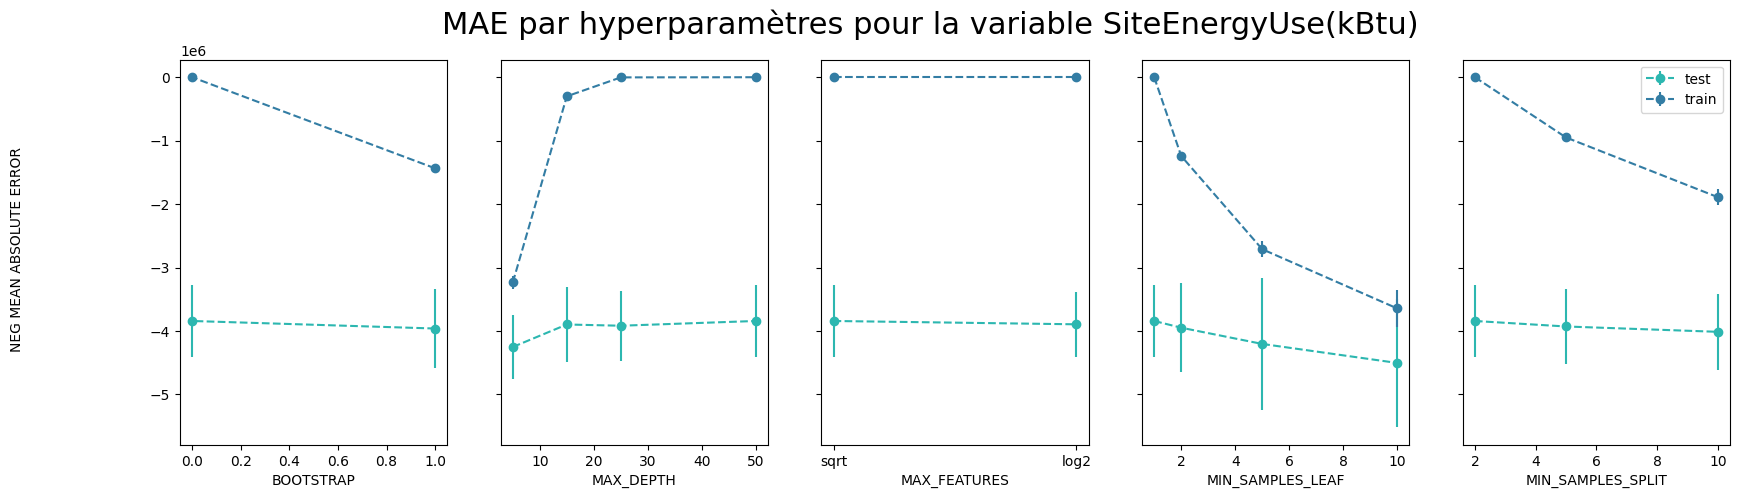


Meilleurs paramètres :
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [49]:
plot_search_results(SEU_random_forest_model.named_steps['grid_search_random_forest'], title="SiteEnergyUse(kBtu)")

regressor__bootstrap: False (échantillonnage sans remplacement)  
regressor__max_depth: 50  (profondeur maximale des arbres de décision)  
regressor__max_features: sqrt (sqrt du nombre total de caractéristiques à considérer lors de la recherche de la meilleure division à chaque nœud)  
regressor__min_samples_leaf: 1  (nombre minimum d'échantillons requis pour être à un nœud terminal (feuille) de l'arbre)  
regressor__min_samples_split: 2  (nombre minimum d'échantillons requis pour effectuer une division à un nœud)


<a id='feature-importance-seu'></a>
#### Feature importance du modèle RandomForestRegressor sur la consommation d'énergie

In [50]:
def get_feature_names(preprocessor):
    if isinstance(preprocessor, ColumnTransformer):
        feature_names = []
        for transformer in preprocessor.transformers_:
            if isinstance(transformer[1], Pipeline):
                feature_names.extend(transformer[1].named_steps['encoder'].get_feature_names_out())
            else:
                feature_names.extend(transformer[2])
    else:
        feature_names = preprocessor.get_feature_names_out()
    return feature_names


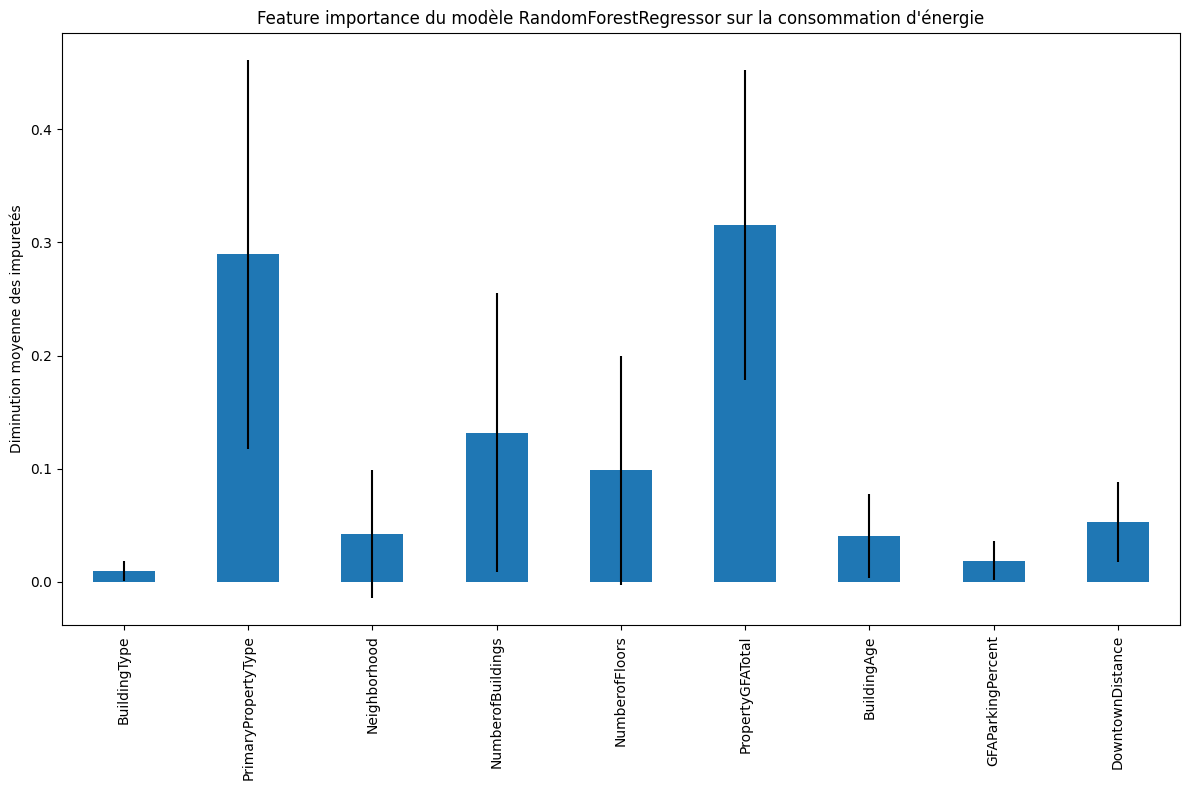

In [51]:
best_random_forest = SEU_random_forest_model.named_steps['grid_search_random_forest'].best_estimator_

feature_importance = best_random_forest.feature_importances_

features_names = get_feature_names(SEU_random_forest_model.named_steps['preprocessor'])

std = np.std([tree.feature_importances_ for tree in best_random_forest.estimators_], axis=0)

df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance du modèle RandomForestRegressor sur la consommation d'énergie")
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()


<a id='true-pred-seu'></a>
#### Comparaison entre les valeurs réelles et les valeurs prédites (jeu de test initial)

In [52]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [53]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites / valeurs réélles de la variable {}".format(title), 
               fontsize=18)
    plt.show()

In [54]:
import time
start_time = time.time()

SEU_pred = SEU_random_forest_model.predict(X_test)
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'agorithme : 0.035 s.


In [55]:
SEUmetrics = metrics_model(Y_test['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,5.465697e+06
1,R²,2.577615e-01


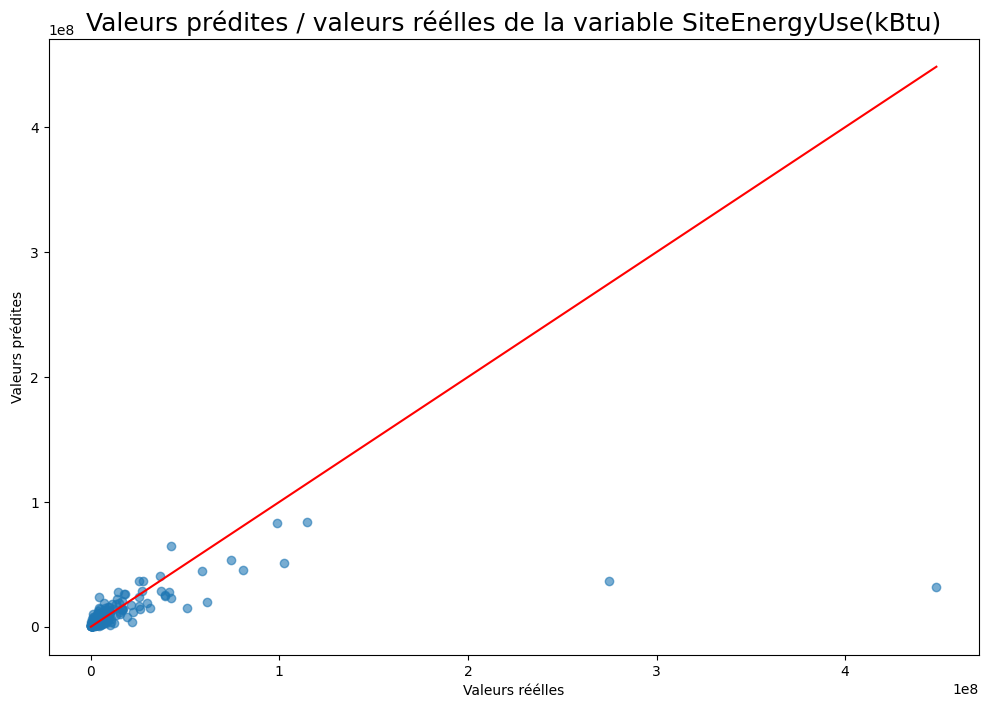

In [56]:
plot_pred_true(Y_test['SiteEnergyUse(kBtu)'],SEU_pred, title="SiteEnergyUse(kBtu)")